The empirical exercise should focus on how the sector and factor tilting works when a crisis comes, better diversification provided, consistent risk factor contributions, and greater resilience to economic shocks 

In [6]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import cvxpy as cp
from tqdm.notebook import tqdm
from regimeaware.routines import cfg
from itertools import product
from scipy.stats import entropy
from regimeaware.core import utils

# rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)
rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq='M')

# Data
rt_ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl')[cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Reference market cap weights
mktcap = crsp['mktcap'].copy()
ref_wts = mktcap.groupby('permno').shift(1).reindex(factor_loadings.index.droplevel('factor').unique())
ref_wts = ref_wts.div(ref_wts.groupby('date').sum())

bm = ref_wts.groupby('id').shift(1).mul(crsp['excess_ret'].reindex(ref_wts.index)).groupby('date').sum().add(1).cumprod()

$$
\begin{equation}
\begin{aligned}
& \underset{w}{\text{argmin}} & & \gamma \left( w^{T} F^{T} \Sigma_{f} F w + w^{T} E w \right) - w^{T} \mu_{f} \\
& \text{s.t.} & & (w - b)^{T} \Sigma (w - b) \leq \bar{\sigma}^{2} \\
& & & \sum_{i=1}^{N} w_i = 1 \\
& & &  w_i \geq 0 \; ; \; \forall \; i =1, \ldots, N \\
\end{aligned}
\end{equation}
$$

In [5]:
collect_w = {}

for g, dt in product(cfg.gamma_iter, rebalance_dts):
    print(f'Gamma: {g}, Date: {dt.strftime("%Y %b")}', end='       \r')
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ (w - b),
        w >= 0
    ]

    gamma.value = g

    prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[(g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['gamma', 'date']

collect_bt = {}
for g in cfg.gamma_iter:
    wt = wts.xs(g)
    collect_bt[g] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}' for x in bt.columns]

df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12))
display(ir.sort_values())
display(sr.sort_values())

KeyError: 0

Gamma: 90    0.027648
Gamma: 80    0.040784
Gamma: 70    0.049876
Gamma: 60    0.055762
Gamma: 50    0.062895
Gamma: 40    0.068811
Gamma: 30    0.074412
Gamma: 10    0.089976
Gamma: 20    0.104028
dtype: float64

Gamma: 10    0.512962
Gamma: 20    0.566805
Gamma: 30    0.579534
Gamma: 40    0.593549
Gamma: 50    0.602192
Gamma: 60    0.607382
Gamma: 70    0.611596
Gamma: 80    0.613845
Gamma: 90    0.614628
Benchmark    0.635878
dtype: float64

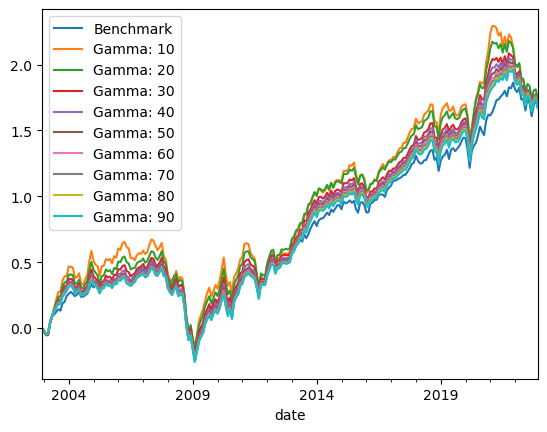

In [10]:

collect_bt = {}
for g in cfg.gamma_iter:
    wt = wts.xs(g)
    collect_bt[g] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}' for x in bt.columns]

df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12))
display(ir.sort_values())
display(sr.sort_values())


In [11]:
tracking

,Gamma: 10,Gamma: 20,Gamma: 30,Gamma: 40,Gamma: 50,Gamma: 60,Gamma: 70,Gamma: 80,Gamma: 90
date,,,,,,,,,
2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-31,0.019855,0.006930,0.004058,0.003781,0.004131,0.004516,0.004719,0.004848,0.004915
2003-02-28,-0.020261,-0.012989,-0.009339,-0.006937,-0.005826,-0.004925,-0.004099,-0.003647,-0.003265
2003-03-31,-0.016794,-0.009092,-0.005566,-0.002628,-0.000923,0.000082,0.000600,0.001044,0.001278
2003-04-30,0.009319,0.015674,0.011338,0.010030,0.009119,0.008793,0.007986,0.007433,0.007367
...,...,...,...,...,...,...,...,...,...
2022-08-31,0.042899,0.022659,0.017226,0.013621,0.011970,0.010771,0.009774,0.008626,0.007610
2022-09-30,-0.011957,-0.001890,0.000961,0.002238,0.003046,0.003590,0.003873,0.004051,0.004275
2022-10-31,-0.015620,-0.013317,-0.012324,-0.012156,-0.012104,-0.011412,-0.010782,-0.010491,-0.010186


In [ ]:
df.apply(np.log).plot()

# TODO: Just work without the TEV constraint, in relative weights terms, and just control the gamma

Obs
- Higher TEV-Budget leads to better IR
- Higher risk aversion leads to lower IR? 

In [ ]:
from scipy.stats import entropy

transmat = pd.read_pickle(f'{cfg.data_fldr}/regimes/transmat.pkl')
emission_prob = pd.read_pickle(f'{cfg.data_fldr}/regimes/emission_prob.pkl')
h = emission_prob.groupby('as_of').last().apply(entropy, axis=1)
h.mul(5).add(20).plot()

In [ ]:
collect_w = {}
# test_g = [5, 10, 15, 20, 25, 30, 35, 50]
for dt in rebalance_dts:
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    # port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ F @ (w - b)

    constraints = [
        cp.sum(w) == 1,
        # f == F @ w,
        w >= 0
    ]

    gamma.value = h[dt] * 10 + 55

    prob = cp.Problem(cp.Maximize(port_return - gamma * tracking_error), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[dt] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['date']
bt = wts.shift(1).mul(rt.add(1).groupby(pd.Grouper(freq='Q')).prod().sub(1).replace(0, np.nan)).dropna(how='all').sum(axis=1)
bt = bt.reindex(bm.index).fillna(0)
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod().rename('Backtest'))
df.apply(np.log).resample('Q').last().loc[:'2021'].plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1).loc[:'2021']
print('IR')
display(tracking.mean().div(tracking.std()).mul(np.sqrt(4)).sort_values())
display(tracking.std().item() * np.sqrt(4))
print('SR')
display(df.loc[:'2021'].pct_change().mean().div(df.loc[:'2021'].pct_change().std()).mul(np.sqrt(4)).sort_values())


In [ ]:
collect_w = {}
# test_g = [5, 10, 15, 20, 25, 30, 35, 50]
for dt in rebalance_dts:
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    # port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ F @ (w - b)

    constraints = [
        cp.sum(w) == 1,
        # f == F @ w,
        w >= 0
    ]

    gamma.value = h[dt] * 5 + 25

    prob = cp.Problem(cp.Maximize(port_return - gamma * tracking_error), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[dt] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['date']
bt = wts.shift(1).mul(rt).dropna(how='all').sum(axis=1)
bt = bt.reindex(bm.index).fillna(0)
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod().rename('Backtest'))
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
print('IR')
display(tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values())
display(tracking.std().item() * np.sqrt(12))
print('SR')
display(df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12)).sort_values())


In [ ]:
"""
MVO is giving issues because the matrix is not invertible
When I do dropna gives me back two obervations, which should be wrong, as the tradabale securities have betas, and to have a beta we require 10 years of obervations (120 obs)
For this reason, I'd expect each stock to have the last 120 obs valid

Confirmed, the matrix is not invertible and that was causing the issues while optimizing

Compared to: Historical beta estimation
"""

In [ ]:
collect_w = {}

for window in cfg.ols_windows:
    factor_loadings_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_betas_{window}.pkl')
    factor_variance_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_var_{window}.pkl')
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            for dt in tqdm(rebalance_dts, desc=f'window: {window}, gamma: {g}, te budget: {t * 100}%'):
                # Data handling
                sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
                
                factor_sample = rt_ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].iloc[-window:]
                mu_f = factor_sample.mean().values.reshape(-1, 1)
                mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
                Sigma_f = factor_sample.cov().values
                
                
                F = utils.unpack_betas(factor_loadings_ols.xs(dt)).reindex(sec_ids).values.T
                E = np.diag(factor_variance_ols.xs(dt).reindex(sec_ids))
                b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
                b = np.divide(b, b.sum())

                # Optimization problem
                tev_budget = cp.Parameter(nonneg=True)
                gamma = cp.Parameter(nonneg=True)

                m, n = F.shape
                w = cp.Variable((n, 1))
                f = cp.Variable((m, 1))

                Sigma_f_const = np.zeros((m, m))
                Sigma_f_const[1:, 1:] = Sigma_f

                tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
                port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
                port_return = mu_f_const.T @ f

                constraints = [
                    cp.sum(w) == 1,
                    f == F @ w,
                    w >= 0,
                    tracking_error <= tev_budget 
                ]

                gamma.value = g
                tev_budget.value = (t / 12) ** 2 

                prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
                prob.solve(verbose=False, solver=cp.CLARABEL)
                collect_w[(window, t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)


In [ ]:
wts

In [ ]:
wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)

collect_bt = {}
for w in cfg.ols_windows:
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            wt = wts.xs(w).xs(t).xs(g)
            collect_bt[(w, g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt_ols = pd.DataFrame.from_dict(collect_bt)
bt_ols = bt_ols.reindex(bm.index).fillna(0)
bt_ols.columns = [f'OLS-{w}M Gamma: {x}\nTE Budget: {y * 100}' for w, x, y in bt_ols.columns]

In [ ]:
df = bm.to_frame(name='Benchmark').join(bt_ols.add(1).cumprod())
df.apply(np.log).plot()

In [ ]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

In [ ]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()